**Make sure you run this at the begining**

In [1]:
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt

# Append template path to sys path
sys.path.append(os.getcwd() + "/template") 

In [2]:
from utils.load_data import load_data
from utils.load_data import log
from utils.visualize_tsp import plotTSP
from utils.tsp import TSP
from utils.tsp import TSP_Bench
from utils.tsp import TSP_Bench_ALL

# Workshop Starts Here

<img src="images/tsp.jpg" alt="TSP" style="width: 900px;"/>

<img src="images/solutions.png" alt="solutions" style="width: 900px;"/>

# Get familiar with your dataset

There are problems at different levels. **3 simple, 2 medium, 1 hard**.

In [3]:
for root, _, files in os.walk('./template/data'):
    if(files):
        for f in files:
            print(str(root) + "/" + f)

./template/data/medium/pcb442.tsp
./template/data/medium/a280.tsp
./template/data/hard/dsj1000.tsp
./template/data/simple/att48.tsp
./template/data/simple/ulysses16.tsp
./template/data/simple/st70.tsp


In [4]:
ulysses16 = np.array(load_data("./template/data/simple/ulysses16.tsp"))

In [5]:
ulysses16[:]

array([[38.24, 20.42],
       [39.57, 26.15],
       [40.56, 25.32],
       [36.26, 23.12],
       [33.48, 10.54],
       [37.56, 12.19],
       [38.42, 13.11],
       [37.52, 20.44],
       [41.23,  9.1 ],
       [41.17, 13.05],
       [36.08, -5.21],
       [38.47, 15.13],
       [38.15, 15.35],
       [37.51, 15.17],
       [35.49, 14.32],
       [39.36, 19.56]])

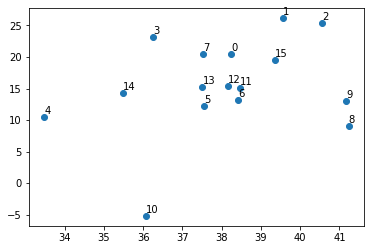

In [6]:
plt.scatter(ulysses16[:, 0], ulysses16[:, 1])
for i in range(0, 16):
    plt.annotate(i, (ulysses16[i, 0], ulysses16[i, 1]+0.5))

## Naive Solution: In Order

In [7]:
simple_sequence = list(range(0, 16))
print(simple_sequence)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


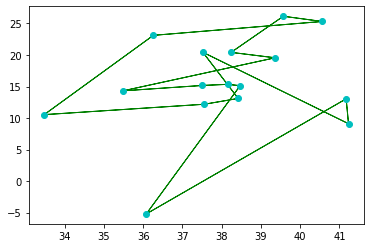

In [8]:
plotTSP([simple_sequence], ulysses16, num_iters=1)

## Naive Solution: Random Permutation

In [9]:
random_permutation = np.random.permutation(16).tolist()
print(random_permutation)

[9, 8, 3, 7, 0, 13, 15, 4, 11, 10, 2, 14, 12, 6, 5, 1]


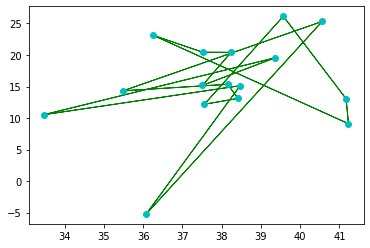

In [10]:
plotTSP([random_permutation], ulysses16, num_iters=1)

## Best Solution

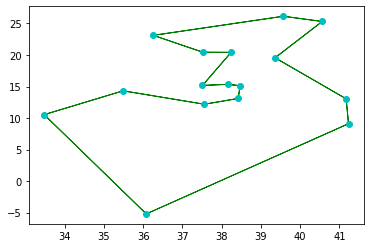

In [11]:
best_ulysses16 = [0, 13, 12, 11, 6, 5, 14, 4, 10, 8, 9, 15, 2, 1, 3, 7]
plotTSP([best_ulysses16], ulysses16, num_iters=1)

## Calculate Fitness (Sum of all Distances)

In [12]:
def dist(node_0, node_1, coords):
        """
        Euclidean distance between two nodes.
        """
        coord_0, coord_1 = coords[node_0], coords[node_1]
        return math.sqrt((coord_0[0] - coord_1[0]) ** 2 + (coord_0[1] - coord_1[1]) ** 2)

In [13]:
print("Coordinate of City 0:", ulysses16[0])

Coordinate of City 0: [38.24 20.42]


In [14]:
print("Coordinate of City 1:", ulysses16[1])

Coordinate of City 1: [39.57 26.15]


In [15]:
print("Distance Between", dist(0, 1, ulysses16))

Distance Between 5.882329470541408


In [16]:
def fitness(solution, coords):
    N = len(coords)
    cur_fit = 0
    for i in range(len(solution)):
        cur_fit += dist(solution[i % N], solution[(i + 1) % N], coords)
    return cur_fit

In [17]:
print ("Order Fitness:\t", fitness(simple_sequence, ulysses16))
print ("Random Fitness:\t", fitness(random_permutation, ulysses16))
print ("Best Fitness:\t", fitness(best_ulysses16, ulysses16))

Order Fitness:	 104.42225210207233
Random Fitness:	 147.23709375479442
Best Fitness:	 74.10873595815309


## Naive Random Model

In [18]:
import math
import random
from model.base_model import Model

class MyRandomModel(Model):
    def __init__(self):
        super().__init__()

    def init(self, nodes):
        """
        Put your initialization here.
        """
        super().init(nodes)

    def fit(self, max_it):
        """
        Put your iteration process here.
        """
        random_solutions = []
        for i in range(0, max_it):
            solution = np.random.permutation(self.N).tolist()
            random_solutions.append(solution)
            self.fitness_list.append(self.fitness(solution))

        self.best_solution = random_solutions[self.fitness_list.index(min(self.fitness_list))]
        return self.best_solution, self.fitness_list

In [19]:
tsp_file = './template/data/simple/ulysses16.tsp'

In [20]:
model = MyRandomModel()
best_solution, fitness_list, time = TSP_Bench(tsp_file, model, max_it=100)

[*] [Node] 16, [Best] 109.76627855420857
[*] Running for: 0.01 seconds



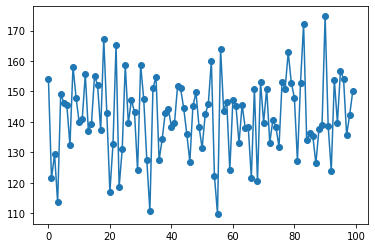

In [21]:
plt.plot(fitness_list, 'o-')

## Minimum Spanning Tree (Depth First)

In [22]:
import math
import random
from model.base_model import Model

class MyDFSModel(Model):
    def __init__(self):
        super().__init__()

    def init(self, nodes):
        """
        Put your initialization here.
        """
        super().init(nodes)

    def fit(self, max_it):
        """
        Put your iteration process here.
        """

        MST_solutions = []
        # Depth First: Set one city as starting point, iterate to the end, then select next city as starting point.
        for i in range(0, self.N):
            solution = []
            solution.append(i)
            unvisited_list = list(range(0, self.N))
            cur_city = i
#             print("[starting]", i)
            for steps in range(self.N - 1):
#                 print(unvisited_list)
                unvisited_list.remove(cur_city)
                closest_neighbour = -1
                shortest_distance = math.inf
                for j in unvisited_list:
                    if(self.dist(cur_city, j) < shortest_distance):
                        closest_neighbour = j
                        shortest_distance = self.dist(cur_city, j)
                solution.append(closest_neighbour)
                cur_city = closest_neighbour
            MST_solutions.append(solution)
            self.fitness_list.append(self.fitness(solution))

        self.best_solution = MST_solutions[ self.fitness_list.index(min(self.fitness_list)) ]

        return self.best_solution, self.fitness_list

In [23]:
tsp_file = './template/data/simple/ulysses16.tsp'
model = MyDFSModel()

In [24]:
best_solution, fitness_list, time = TSP_Bench(tsp_file, model)

[*] [Node] 16, [Best] 77.12688501241215
[*] Running for: 0.01 seconds



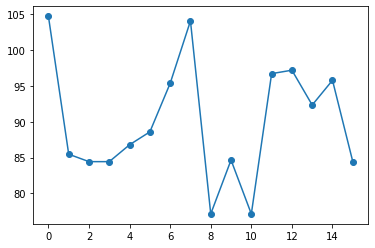

In [25]:
plt.plot(fitness_list, 'o-')

## Minimum Spanning Tree (Breadth First)

In [26]:
import math
import random
from model.base_model import Model

class MyBFSModel(Model):
    def __init__(self):
        super().__init__()

    def init(self, nodes):
        """
        Put your initialization here.
        """
        super().init(nodes)

    def fit(self, max_it):
        """
        Put your iteration process here.
        """

        UCS_solutions = []
    
        for i in range(0, self.N):
            solution = [i]
            UCS_solutions.append(solution)
    
        # Breadth First: Set each city as starting point, then go to next city simultaneously
        for step in range(0, self.N - 1):
            # print("[step]", step)
            unvisited_list = list(range(0, self.N))
            # For each search path
            for i in range(0, self.N):
                cur_city = UCS_solutions[i][-1]
                unvisited_list = list( set(range(0, self.N)) - set(UCS_solutions[i]) )
                # print(unvisited_list)
                closest_neighbour = -1
                shortest_distance = math.inf
                for j in unvisited_list:
                    if(self.dist(cur_city, j) < shortest_distance):
                        closest_neighbour = j
                        shortest_distance = self.dist(cur_city, j)
                UCS_solutions[i].append(closest_neighbour)

        for i in range(0, self.N):
            self.fitness_list.append(self.fitness(UCS_solutions[i]))
 
        self.best_solution = UCS_solutions[ self.fitness_list.index(min(self.fitness_list)) ]
        self.fitness_list.append(self.fitness(self.best_solution))

        return self.best_solution, self.fitness_list

In [27]:
tsp_file = './template/data/simple/ulysses16.tsp'
model = MyBFSModel()

In [28]:
best_solution, fitness_list, time = TSP_Bench(tsp_file, model)

[*] [Node] 16, [Best] 77.12688501241215
[*] Running for: 0.01 seconds



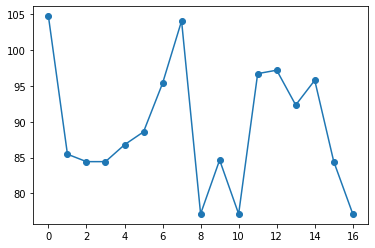

In [29]:
plt.plot(fitness_list, 'o-')

## Dynamic Programming (DFS)

Costs a lot of memory

In [30]:
import math
import random
from model.base_model import Model

class MyDPDModel(Model):
    def __init__(self):
        super().__init__()

    def init(self, nodes):
        """
        Put your initialization here.
        """
        super().init(nodes)

    def getMST(self, node):
        MST = []
        distances = []
        for i in range(0, self.N):
            if i != node:
                MST.append(i)
                distances.append(self.dist(node, i))
        return [x for _,x in sorted(zip(distances, MST))]

    def fit(self, max_it):
        """
        Put your iteration process here.
        """

        MST_solutions = []

        # Depth First: Set one city as starting point, iterate to the end, then select next city as starting point.
        MSTs = []
        for i in range(0, self.N):
            MSTs.append([-1] * self.N)
        for i in range(0, self.N):
            solution = []
            solution.append(i)
            unvisited_list = list(range(0, self.N))
            cur_city = i
            # print("[starting]", i)
            for steps in range(self.N - 1):
                # print(unvisited_list)
                unvisited_list.remove(cur_city)
                if MSTs[cur_city][0] == -1:
                    MST = self.getMST(cur_city)
                    MSTs[cur_city] = MST
                
                for j in MSTs[cur_city]:
                    if(j in unvisited_list):
                        solution.append(j)
                        cur_city = j
                        break
            # print(solution)
            MST_solutions.append(solution)
            self.fitness_list.append(self.fitness(solution))

        self.best_solution = MST_solutions[ self.fitness_list.index(min(self.fitness_list)) ]

        return self.best_solution, self.fitness_list

In [31]:
tsp_file = './template/data/simple/ulysses16.tsp'
model = MyDPDModel()

In [32]:
best_solution, fitness_list, time = TSP_Bench(tsp_file, model)

[*] [Node] 16, [Best] 77.12688501241215
[*] Running for: 0.00 seconds



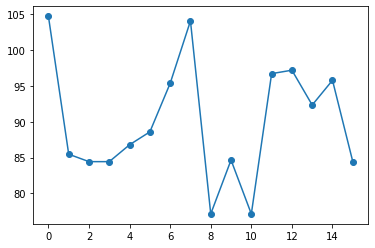

In [33]:
plt.plot(fitness_list, 'o-')

## Dynamic Programming (BFS)

In [34]:
import math
import random
from model.base_model import Model

class MyDPBModel(Model):
    def __init__(self):
        super().__init__()

    def init(self, nodes):
        """
        Put your initialization here.
        """
        super().init(nodes)

    def getMST(self, node):
        MST = []
        distances = []
        for i in range(0, self.N):
            if i != node:
                MST.append(i)
                distances.append(self.dist(node, i))
        return [x for _,x in sorted(zip(distances, MST))]

    def fit(self, max_it):
        """
        Put your iteration process here.
        """

        MST_solutions = []
    
        for i in range(0, self.N):
            solution = [i]
            MST_solutions.append(solution)
    
        MSTs = []
        for i in range(0, self.N):
            MSTs.append([-1] * self.N)

        # Breadth First: Set each city as starting point, then go to next city simultaneously
        for step in range(0, self.N - 1):
            # print("[step]", step)
            unvisited_list = list(range(0, self.N))
            # For each search path
            for i in range(0, self.N):
                cur_city = MST_solutions[i][-1]
                unvisited_list = list( set(range(0, self.N)) - set(MST_solutions[i]) )

                if MSTs[cur_city][0] == -1:
                    MST = self.getMST(cur_city)
                    MSTs[cur_city] = MST

                for j in MSTs[cur_city]:
                    if(j in unvisited_list):
                        MST_solutions[i].append(j)
                        break

        for i in range(0, self.N):
            self.fitness_list.append(self.fitness(MST_solutions[i]))
 
        self.best_solution = MST_solutions[ self.fitness_list.index(min(self.fitness_list)) ]
        self.fitness_list.append(self.fitness(self.best_solution))

        return self.best_solution, self.fitness_list

In [35]:
tsp_file = './template/data/simple/ulysses16.tsp'
model = MyDPBModel()

In [36]:
best_solution, fitness_list, time = TSP_Bench(tsp_file, model)

[*] [Node] 16, [Best] 77.12688501241215
[*] Running for: 0.00 seconds



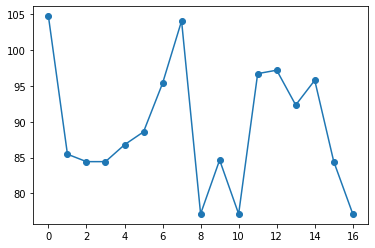

In [37]:
plt.plot(fitness_list, 'o-')

## Your Smart Model

In [38]:
import math
import random
from model.base_model import Model

class MyModel(Model):
    def __init__(self):
        super().__init__()

    def init(self, nodes):
        """
        Put your initialization here.
        """
        super().init(nodes)

        self.log("Nothing to initialize in your model now")

    def fit(self, max_it):
        """
        Put your iteration process here.
        """
        self.best_solution = np.random.permutation(self.N).tolist()
        self.fitness_list.append(self.fitness(self.best_solution))

        return self.best_solution, self.fitness_list

## Test your Model

In [39]:
tsp_problem = './template/data/simple/ulysses16.tsp'
model = MyModel()

In [40]:
best_solution, fitness_list, time = TSP_Bench(tsp_file, model)

[MyModel] Nothing to initialize in your model now
[*] [Node] 16, [Best] 148.6111649037806
[*] Running for: 0.00 seconds



## Test All Dataset

In [41]:
for root, _, files in os.walk('./template/data'):
    if(files):
        for f in files:
            print(str(root) + "/" + f)

./template/data/medium/pcb442.tsp
./template/data/medium/a280.tsp
./template/data/hard/dsj1000.tsp
./template/data/simple/att48.tsp
./template/data/simple/ulysses16.tsp
./template/data/simple/st70.tsp


In [42]:
tsp_path = './template/data'

In [43]:
def plot_results(best_solutions, times, title):
    fig = plt.figure()
    nodes = [len(s) for s in best_solutions]
    data = np.array([[node, time] for node, time in sorted(zip(nodes, times))])
    plt.plot(data[:, 0], data[:, 1], 'o-')
    fig.suptitle(title, fontsize=20)

In [44]:
model = MyRandomModel()
print("Random Search")
best_solutions, fitness_lists, times = TSP_Bench_ALL(tsp_path, model)

Random Search
[*] ./template/data/medium/pcb442.tsp
[*] [Node] 442, [Best] 728128.1926675908
[*] Running for: 0.47 seconds

[*] ./template/data/medium/a280.tsp
[*] [Node] 280, [Best] 30174.692642901202
[*] Running for: 0.24 seconds

[*] ./template/data/hard/dsj1000.tsp
[*] [Node] 1000, [Best] 526435341.8268128
[*] Running for: 0.92 seconds

[*] ./template/data/simple/att48.tsp
[*] [Node] 48, [Best] 123505.12211442963
[*] Running for: 0.04 seconds

[*] ./template/data/simple/ulysses16.tsp
[*] [Node] 16, [Best] 98.36043449906845
[*] Running for: 0.02 seconds

[*] ./template/data/simple/st70.tsp
[*] [Node] 70, [Best] 3030.2458377657613
[*] Running for: 0.06 seconds



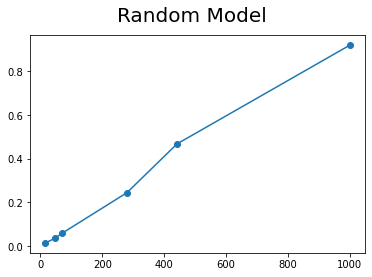

In [45]:
plot_results(best_solutions, times, "Random Model")

In [46]:
model = MyDFSModel()

best_solutions, fitness_lists, times = TSP_Bench_ALL(tsp_path, model)

[*] ./template/data/medium/pcb442.tsp
[*] [Node] 442, [Best] 58952.967129705365
[*] Running for: 31.01 seconds

[*] ./template/data/medium/a280.tsp
[*] [Node] 280, [Best] 3088.6042241002488
[*] Running for: 7.16 seconds

[*] ./template/data/hard/dsj1000.tsp
[*] Timeout -3
[*] Running for: 60.02 seconds

[*] ./template/data/simple/att48.tsp
[*] [Node] 48, [Best] 39236.884898455035
[*] Running for: 0.04 seconds

[*] ./template/data/simple/ulysses16.tsp
[*] [Node] 16, [Best] 77.12688501241215
[*] Running for: 0.00 seconds

[*] ./template/data/simple/st70.tsp
[*] [Node] 70, [Best] 761.6890898866324
[*] Running for: 0.11 seconds



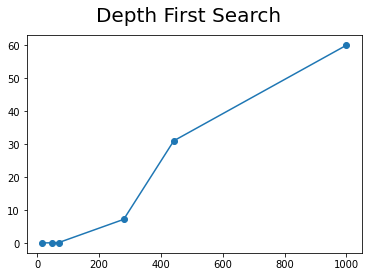

In [47]:
plot_results(best_solutions, times, "Depth First Search")

In [48]:
model = MyBFSModel()

best_solutions, fitness_lists, times = TSP_Bench_ALL(tsp_path, model)

[*] ./template/data/medium/pcb442.tsp
[*] [Node] 442, [Best] 58952.967129705365
[*] Running for: 33.78 seconds

[*] ./template/data/medium/a280.tsp
[*] [Node] 280, [Best] 3088.6042241002488
[*] Running for: 7.97 seconds

[*] ./template/data/hard/dsj1000.tsp
[*] Timeout -3
[*] Running for: 60.02 seconds

[*] ./template/data/simple/att48.tsp
[*] [Node] 48, [Best] 39236.884898455035
[*] Running for: 0.06 seconds

[*] ./template/data/simple/ulysses16.tsp
[*] [Node] 16, [Best] 77.12688501241215
[*] Running for: 0.00 seconds

[*] ./template/data/simple/st70.tsp
[*] [Node] 70, [Best] 761.6890898866324
[*] Running for: 0.14 seconds



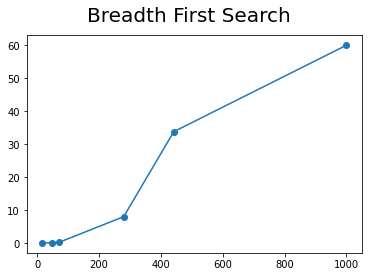

In [49]:
plot_results(best_solutions, times, "Breadth First Search")

In [50]:
model = MyDPDModel()

print("Dynamic Progrmaming")
best_solutions, fitness_lists, times = TSP_Bench_ALL(tsp_path, model)

Dynamic Progrmaming
[*] ./template/data/medium/pcb442.tsp
[*] [Node] 442, [Best] 58952.967129705365
[*] Running for: 2.05 seconds

[*] ./template/data/medium/a280.tsp
[*] [Node] 280, [Best] 3088.6042241002488
[*] Running for: 0.55 seconds

[*] ./template/data/hard/dsj1000.tsp
[*] [Node] 1000, [Best] 22449665.175576296
[*] Running for: 32.57 seconds

[*] ./template/data/simple/att48.tsp
[*] [Node] 48, [Best] 39236.884898455035
[*] Running for: 0.01 seconds

[*] ./template/data/simple/ulysses16.tsp
[*] [Node] 16, [Best] 77.12688501241215
[*] Running for: 0.00 seconds

[*] ./template/data/simple/st70.tsp
[*] [Node] 70, [Best] 761.6890898866324
[*] Running for: 0.02 seconds



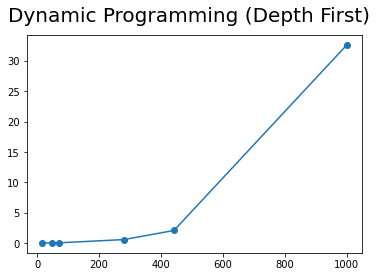

In [51]:
plot_results(best_solutions, times, "Dynamic Programming (Depth First)")

In [52]:
model = MyDPBModel()

print("Dynamic Progrmaming")
best_solutions, fitness_lists, times = TSP_Bench_ALL(tsp_path, model)

Dynamic Progrmaming
[*] ./template/data/medium/pcb442.tsp
[*] [Node] 442, [Best] 58952.967129705365
[*] Running for: 7.77 seconds

[*] ./template/data/medium/a280.tsp
[*] [Node] 280, [Best] 3088.6042241002488
[*] Running for: 2.04 seconds

[*] ./template/data/hard/dsj1000.tsp
[*] Timeout -3
[*] Running for: 60.04 seconds

[*] ./template/data/simple/att48.tsp
[*] [Node] 48, [Best] 39236.884898455035
[*] Running for: 0.02 seconds

[*] ./template/data/simple/ulysses16.tsp
[*] [Node] 16, [Best] 77.12688501241215
[*] Running for: 0.00 seconds

[*] ./template/data/simple/st70.tsp
[*] [Node] 70, [Best] 761.6890898866324
[*] Running for: 0.04 seconds



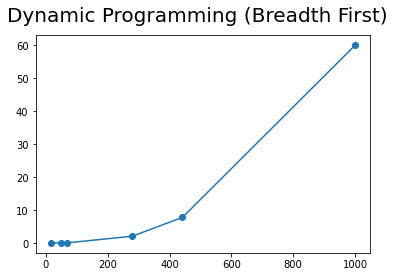

In [53]:
plot_results(best_solutions, times, "Dynamic Programming (Breadth First)")

# Conclusions (Random, BFS, DFS, DP)

In [54]:
# Simple
# ulysses16:   77 (BFS),     84 (DFS)
# att48:    39236 (BFS),  40763 (DFS)
# st70:       761 (BFS),    901 (DFS)

# Medium
# a280:     3088 (BFS),   3558 (DFS)
# pcb442:  58952 (BFS),  61984 (DFS)

# Hard
# dsj1000: time-out (DP-BFS) 23,552,227 (DP-DFS)

<p style="font-size: 18px"> 1. All different models get <strong>the same results</strong> every time (except random). </p>
<p style="font-size: 18px"> 2. All different models have an <strong>exponential time complexity</strong> (except random). </p>
<p style="font-size: 18px"> 3. Depth First Seach is a little faster than Breadth First Search, but Breadth First get better results. </p>
<p style="font-size: 18px"> 4. Only <strong>dynamic programming</strong> solves the problem with 1000 cities (Fast). </p>

In [55]:
# In the next workshop 
# Will try to solve the problem with 1000 cities faster, and get better results